In [1]:
import os
from os.path import exists, join, basename, splitext
import wget

git_repo_url = 'https://github.com/clovaai/CRAFT-pytorch.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  !git clone -q {git_repo_url}
  
import sys
sys.path.append(project_name)
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

In [2]:
 

pretrained_model = './checkpoint/craft_mlt_25k.pth'
if not exists(pretrained_model):
  pretrained_model = wget.download('https://drive.google.com/uc?authuser=0&id=1Jk4eGD7crsqCCg9C9VjCLkMN3ze8kutZ&export=download')

In [3]:
import sys
import os
import time
import argparse

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

from PIL import Image

import sys
sys.path.insert(1, 'CRAFT-pytorch/')

import cv2
from skimage import io
import numpy as np
import craft_utils
import imgproc
import file_utils
import json
import zipfile

from craft import CRAFT

from collections import OrderedDict




In [4]:
def copyStateDict(state_dict):
    if list(state_dict.keys())[0].startswith("module"):
        start_idx = 1
    else:
        start_idx = 0
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = ".".join(k.split(".")[start_idx:])
        new_state_dict[name] = v
    return new_state_dict

def str2bool(v):
    return v.lower() in ("yes", "y", "true", "t", "1")

def test_net(net, image, text_threshold, link_threshold, low_text, cuda, poly, refine_net=None):
    t0 = time.time()

    # resize
    img_resized, target_ratio, size_heatmap = imgproc.resize_aspect_ratio(image, 1280, interpolation=cv2.INTER_LINEAR, mag_ratio=1.5)
    ratio_h = ratio_w = 1 / target_ratio

    # preprocessing
    x = imgproc.normalizeMeanVariance(img_resized)
    x = torch.from_numpy(x).permute(2, 0, 1)    # [h, w, c] to [c, h, w]
    x = Variable(x.unsqueeze(0))                # [c, h, w] to [b, c, h, w]
    if cuda:
        x = x.cuda()

    # forward pass
    with torch.no_grad():
        y, feature = net(x)

    # make score and link map
    score_text = y[0,:,:,0].cpu().data.numpy()
    score_link = y[0,:,:,1].cpu().data.numpy()

    # refine link
    if refine_net is not None:
        with torch.no_grad():
            y_refiner = refine_net(y, feature)
        score_link = y_refiner[0,:,:,0].cpu().data.numpy()

    t0 = time.time() - t0
    t1 = time.time()

    # Post-processing
    boxes, polys = craft_utils.getDetBoxes(score_text, score_link, text_threshold, link_threshold, low_text, poly)

    # coordinate adjustment
    boxes = craft_utils.adjustResultCoordinates(boxes, ratio_w, ratio_h)
    polys = craft_utils.adjustResultCoordinates(polys, ratio_w, ratio_h)
    for k in range(len(polys)):
        if polys[k] is None: polys[k] = boxes[k]

    t1 = time.time() - t1

    # render results (optional)
    render_img = score_text.copy()
    render_img = np.hstack((render_img, score_link))
    ret_score_text = imgproc.cvt2HeatmapImg(render_img)

    return boxes, polys, ret_score_text

def GetResult(img, boxes, texts=None):
        img = np.array(img)
        
        for i, box in enumerate(boxes):
            poly = np.array(box).astype(np.int32).reshape((-1))

            poly = poly.reshape(-1, 2)
            cv2.polylines(img, [poly.reshape((-1, 1, 2))], True, color=(255, 255, 0), thickness=2)

            if texts is not None:
                font = cv2.FONT_HERSHEY_SIMPLEX
                font_scale = 0.5
                cv2.putText(img, "{}".format(texts[i]), (poly[0][0]+1, poly[0][1]+1), font, font_scale, (0, 0, 0), thickness=1)
                cv2.putText(img, "{}".format(texts[i]), tuple(poly[0]), font, font_scale, (0, 255, 255), thickness=1)

        return img        


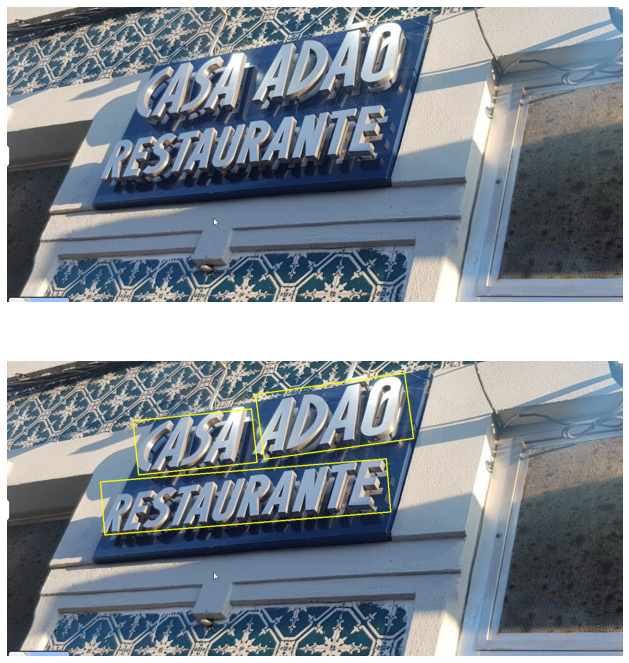

In [5]:
# load net
net = CRAFT()     # initialize

net.load_state_dict(copyStateDict(torch.load('checkpoint/craft_mlt_25k.pth', map_location='cuda')))

net = net.cuda()
net = torch.nn.DataParallel(net)
cudnn.benchmark = False

net.eval()

t = time.time()

# load data
image = imgproc.loadImage("./text/text1.jpg")

bboxes, polys, score_text = test_net(net, image, 0.7, 0.4, 0.4, True, False, None)

px = 1/plt.rcParams['figure.dpi']  # pixel in inches
fig, ax = plt.subplots(2,1,figsize=(860*px, 860*px))
ax[0].axis('off')
ax[0].imshow(image)

ax[1].axis('off')
ax[1].imshow(GetResult(image, polys))